In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.8.0'

### define BN layer for MLP

In [10]:
class BNLayer(keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BNLayer, self).__init__()
        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, training=True):
        """forward
        BN(x) = gamma * ((x - mu) / sqrt(var + epsilon)) + beta
        """

        self.it_call += 1

        if training:
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            # training: compute BN 
            batch_mu = tf.math.reduce_mean(inputs, axis=0)
            batch_var = tf.math.reduce_variance(inputs, axis=0)
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_mu = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else:
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs


    

### define MLP

In [11]:
class MLP(tf.keras.Model):
    def __init__(self, input_size, output_size, hidden_size,
                 before_activation_bn=True):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.before_activation_bn = before_activation_bn

        self.input_layer = keras.layers.Dense(hidden_size, activation=None)
        self.hidden1 = keras.layers.Dense(hidden_size, activation=None)
        self.bn1 = BNLayer(hidden_size)
        self.hidden2 = keras.layers.Dense(hidden_size, activation=None)
        self.bn2 = BNLayer(hidden_size)
        self.output_layer = keras.layers.Dense(output_size, activation=None)
        

    def call(self, inputs, training=True):
        x = tf.cast(inputs, dtype=tf.float32)
        x = self.input_layer(inputs)
        x = tf.nn.relu(x)

        if self.before_activation_bn:
            x = self.hidden1(x)
            x = self.bn1(x, training=training)
            x = tf.nn.relu(x)
            x = self.hidden2(x)
            x = self.bn2(x, training=training)
            x = tf.nn.relu(x)
        else:
            x = self.hidden1(x)
            x = tf.nn.relu(x)
            x = self.bn1(x, training=training)
            x = self.hidden2(x)
            x = tf.nn.relu(x)
            x = self.bn2(x, training=training)
        
        x = self.output_layer(x)
        return x
    

### Report performance of MLP model

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = tf.reshape(x_train, (x_train.shape[0], -1))
x_test = tf.reshape(x_test, (x_test.shape[0], -1))

x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


#### apply BN after pre-activation: g(BN(f(x)))

In [14]:
input_size = 28 * 28
output_size = 10
hidden_size = 1024
before_activation_bn = True

accuracy = []
for i in range(3):
    tf.random.set_seed(i + 12)
    model = MLP(input_size, output_size, hidden_size, before_activation_bn=before_activation_bn)

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    acc = keras.metrics.SparseCategoricalAccuracy(name="acc")

    model.compile(optimizer, loss=loss_fn, metrics=[acc])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(x_train, y_train, epochs=20, batch_size=128,
              validation_data=(x_val, y_val),
              callbacks=[callback])

    _, test_accuracy = model.evaluate(x_test, y_test, batch_size=len(x_test))
    accuracy.append(test_accuracy)


Epoch 1/20
391/391 [==============================] - 8s 14ms/step - loss: 1.0788 - acc: 0.8043 - val_loss: 0.5340 - val_acc: 0.8590
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 0.4153 - acc: 0.8752 - val_loss: 0.3652 - val_acc: 0.8780
Epoch 3/20
391/391 [==============================] - 4s 10ms/step - loss: 0.3146 - acc: 0.8936 - val_loss: 0.3234 - val_acc: 0.8858
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 0.2704 - acc: 0.9048 - val_loss: 0.3056 - val_acc: 0.8878
Epoch 5/20
391/391 [==============================] - 4s 10ms/step - loss: 0.2399 - acc: 0.9149 - val_loss: 0.3063 - val_acc: 0.8868
Epoch 6/20
391/391 [==============================] - 4s 10ms/step - loss: 0.2134 - acc: 0.9240 - val_loss: 0.3035 - val_acc: 0.8900
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 0.1914 - acc: 0.9311 - val_loss: 0.2930 - val_acc: 0.8918
Epoch 8/20
391/391 [==============================] - 4s 11ms/step - 

the mean of 3 runs is 0.8901000022888184, and the variance is 5.926694463198601e-06


{'boxes': [<matplotlib.lines.Line2D at 0x7fd3acff5090>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd3acf7add0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd3acee0950>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3acee0cd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd3aceade50>,
  <matplotlib.lines.Line2D at 0x7fd4281e5110>]}

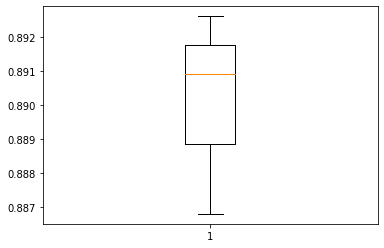

In [15]:
mean = np.mean(accuracy)
var = np.var(accuracy)
print(f"the mean of 3 runs is {mean}, and the variance is {var}")

plt.boxplot(accuracy)

#### apply BN after post_activation: BN(g(f(x)))

In [18]:
input_size = 28 * 28
output_size = 10
hidden_size = 1024
before_activation_bn = False

accuracy = []
for i in range(3):
    tf.random.set_seed(i + 10)
    model = MLP(input_size, output_size, hidden_size, before_activation_bn=before_activation_bn)

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    acc = keras.metrics.SparseCategoricalAccuracy(name="acc")

    model.compile(optimizer, loss=loss_fn, metrics=[acc])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(x_train, y_train, epochs=20, batch_size=128,
              validation_data=(x_val, y_val),
              callbacks=[callback])

    _, test_accuracy = model.evaluate(x_test, y_test, batch_size=len(x_test))
    accuracy.append(test_accuracy)


Epoch 1/20
391/391 [==============================] - 6s 11ms/step - loss: 0.9098 - acc: 0.8046 - val_loss: 0.4968 - val_acc: 0.8585
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 0.3955 - acc: 0.8734 - val_loss: 0.3752 - val_acc: 0.8698
Epoch 3/20
391/391 [==============================] - 4s 10ms/step - loss: 0.3233 - acc: 0.8885 - val_loss: 0.3464 - val_acc: 0.8792
Epoch 4/20
391/391 [==============================] - 4s 11ms/step - loss: 0.2886 - acc: 0.8982 - val_loss: 0.3448 - val_acc: 0.8837
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.2645 - acc: 0.9044 - val_loss: 0.3365 - val_acc: 0.8815
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.2465 - acc: 0.9110 - val_loss: 0.3195 - val_acc: 0.8836
Epoch 7/20
391/391 [==============================] - 6s 15ms/step - loss: 0.2297 - acc: 0.9159 - val_loss: 0.3414 - val_acc: 0.8853
Epoch 8/20
391/391 [==============================] - 5s 12ms/step - 

the mean of 3 runs is 0.8784333268801371, and the variance is 2.3488485404578164e-06


{'boxes': [<matplotlib.lines.Line2D at 0x7fd3ae661e10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd3ae669e90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd3ae66fed0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3ae66f990>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd3ad0da290>,
  <matplotlib.lines.Line2D at 0x7fd3ae669950>]}

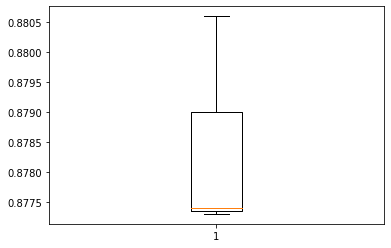

In [19]:
mean = np.mean(accuracy)
var = np.var(accuracy)
print(f"the mean of 3 runs is {mean}, and the variance is {var}")

plt.boxplot(accuracy)

### define BN layer for CNN

In [20]:
class BNLayer(keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BNLayer, self).__init__()
        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, training=True):
        """forward
        BN(x) = gamma * ((x - mu) / sqrt(var + epsilon)) + beta
        """

        self.it_call += 1

        if training:
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            # training: compute BN 
            batch_mu = tf.math.reduce_mean(inputs, axis=(0,1,2))
            batch_var = tf.math.reduce_variance(inputs, axis=(0,1,2))
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_mu = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else:
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

### define CNN

In [24]:
class ImageRecognitionCNN(tf.keras.Model):
    def __init__(self, num_classes,
                 filter=64,
                 kernel=3, 
                 before_activation_bn=True):
        super(ImageRecognitionCNN, self).__init__()
        self.filter=64
        self.kernel=3
        self.before_activation_bn = before_activation_bn

        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(filter, kernel, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(filter, kernel, padding='same', activation=None)
        self.bn1 = BNLayer(filter)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(filter, kernel, padding='same', activation=None)
        self.bn2 = BNLayer(filter)
        self.conv4 = tf.keras.layers.Conv2D(filter, kernel, padding='same', activation=None)
        self.bn3 = BNLayer(filter)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
    

    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        if self.before_activation_bn:
            x = self.conv2(x)
            x = self.bn1(x)
            x = tf.nn.relu(x)
            x = self.pool1(x)

            x = self.conv3(x)
            x = self.bn2(x)
            x = tf.nn.relu(x)
            x = self.pool1(x)

            x = self.conv4(x)
            x = self.bn3(x)
            x = tf.nn.relu(x)
            x = self.pool1(x)
            x = self.conv8(x)
        else:
            x = self.conv2(x)
            x = tf.nn.relu(x)
            x = self.bn1(x)
            x = self.pool1(x)

            x = self.conv3(x)
            x = tf.nn.relu(x)
            x = self.bn2(x)
            x = self.pool1(x)

            x = self.conv4(x)
            x = tf.nn.relu(x)
            x = self.bn3(x)
            x = self.pool1(x)
            x = self.conv8(x)
        
        x = tf.reshape(x, (-1, 10))
        return x
        

### Report performance of CNN model

In [22]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32').reshape(-1,28,28,1) / 255
x_test = x_test.astype('float32').reshape(-1,28,28,1) / 255

x_val = x_train[50000:60000]
x_train = x_train[0:50000]

y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 28, 28, 1)
(50000,)
(10000, 28, 28, 1)
(10000,)
(10000, 28, 28, 1)
(10000,)


#### apply BN after pre-activation: g(BN(f(x)))

In [25]:
num_classes = 10
filter=64
kernel=3 
before_activation_bn = True

accuracy = []
for i in range(3):
    tf.random.set_seed(i + 12)
    model = ImageRecognitionCNN(num_classes, 
                                filter=filter,
                                kernel=kernel, 
                                before_activation_bn=before_activation_bn)

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    acc = keras.metrics.SparseCategoricalAccuracy(name="acc")

    model.compile(optimizer, loss=loss_fn, metrics=[acc])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(x_train, y_train, epochs=50, batch_size=128,
              validation_data=(x_val, y_val),
              callbacks=[callback])

    _, test_accuracy = model.evaluate(x_test, y_test, batch_size=len(x_test))
    accuracy.append(test_accuracy)

Epoch 1/50
391/391 [==============================] - 14s 28ms/step - loss: 1.7471 - acc: 0.6469 - val_loss: 1.2436 - val_acc: 0.7794
Epoch 2/50
391/391 [==============================] - 12s 31ms/step - loss: 0.9362 - acc: 0.8097 - val_loss: 0.6971 - val_acc: 0.8335
Epoch 3/50
391/391 [==============================] - 11s 29ms/step - loss: 0.5821 - acc: 0.8534 - val_loss: 0.4907 - val_acc: 0.8663
Epoch 4/50
391/391 [==============================] - 11s 27ms/step - loss: 0.4265 - acc: 0.8798 - val_loss: 0.3920 - val_acc: 0.8825
Epoch 5/50
391/391 [==============================] - 11s 27ms/step - loss: 0.3475 - acc: 0.8945 - val_loss: 0.3351 - val_acc: 0.8903
Epoch 6/50
391/391 [==============================] - 11s 27ms/step - loss: 0.2993 - acc: 0.9045 - val_loss: 0.3022 - val_acc: 0.9016
Epoch 7/50
391/391 [==============================] - 11s 27ms/step - loss: 0.2686 - acc: 0.9123 - val_loss: 0.2769 - val_acc: 0.9065
Epoch 8/50
391/391 [==============================] - 11s 27ms

the mean of 3 runs is 0.9144999782244364, and the variance is 3.3799852880002213e-06


{'boxes': [<matplotlib.lines.Line2D at 0x7fd3acf90a90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd3ad11b810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd3ad123850>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3ad123310>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd3acef9110>,
  <matplotlib.lines.Line2D at 0x7fd3ad11b2d0>]}

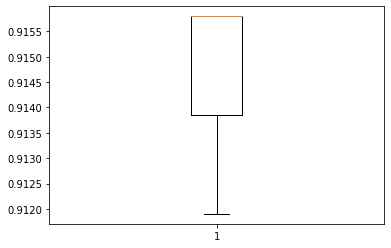

In [26]:
mean = np.mean(accuracy)
var = np.var(accuracy)
print(f"the mean of 3 runs is {mean}, and the variance is {var}")

plt.boxplot(accuracy)

#### apply BN after post_activation: BN(g(f(x)))

In [27]:
num_classes = 10
filter=64
kernel=3 
before_activation_bn = False

accuracy = []
for i in range(3):
    tf.random.set_seed(i + 24)
    model = ImageRecognitionCNN(num_classes, 
                                filter=filter,
                                kernel=kernel, 
                                before_activation_bn=before_activation_bn)

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    acc = keras.metrics.SparseCategoricalAccuracy(name="acc")

    model.compile(optimizer, loss=loss_fn, metrics=[acc])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(x_train, y_train, epochs=50, batch_size=128,
              validation_data=(x_val, y_val),
              callbacks=[callback])

    _, test_accuracy = model.evaluate(x_test, y_test, batch_size=len(x_test))
    accuracy.append(test_accuracy)

Epoch 1/50
391/391 [==============================] - 13s 28ms/step - loss: 1.6355 - acc: 0.6689 - val_loss: 1.1108 - val_acc: 0.8044
Epoch 2/50
391/391 [==============================] - 11s 27ms/step - loss: 0.8247 - acc: 0.8272 - val_loss: 0.6148 - val_acc: 0.8453
Epoch 3/50
391/391 [==============================] - 11s 28ms/step - loss: 0.5176 - acc: 0.8653 - val_loss: 0.4445 - val_acc: 0.8722
Epoch 4/50
391/391 [==============================] - 11s 28ms/step - loss: 0.3904 - acc: 0.8846 - val_loss: 0.3714 - val_acc: 0.8868
Epoch 5/50
391/391 [==============================] - 11s 27ms/step - loss: 0.3267 - acc: 0.8978 - val_loss: 0.3259 - val_acc: 0.8915
Epoch 6/50
391/391 [==============================] - 11s 27ms/step - loss: 0.2883 - acc: 0.9074 - val_loss: 0.2989 - val_acc: 0.8982
Epoch 7/50
391/391 [==============================] - 11s 27ms/step - loss: 0.2624 - acc: 0.9120 - val_loss: 0.2755 - val_acc: 0.9042
Epoch 8/50
391/391 [==============================] - 10s 26ms

the mean of 3 runs is 0.9046000043551127, and the variance is 1.1266233512527733e-06


{'boxes': [<matplotlib.lines.Line2D at 0x7fd3aa6e3d90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd3aa6ec850>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd3aa6f6890>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3aa6f6350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd3ad048950>,
  <matplotlib.lines.Line2D at 0x7fd3aa6ec310>]}

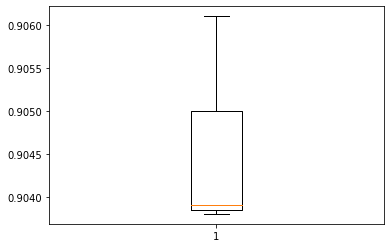

In [28]:
mean = np.mean(accuracy)
var = np.var(accuracy)
print(f"the mean of 3 runs is {mean}, and the variance is {var}")

plt.boxplot(accuracy)